# Pregel Programing Model
- each vertex executes code once graph is loaded
- each vertex knows its outgoing eges
- vertices are distributed across processors

Superstep: each vertex
- receives messages from in-neightbots
- ... computation ...
- sends messages to out-neighbours
- decides whether or not to halt
- (halt: vertex stays inactive except if it receives a message)

computation halts if all vertices are in halt state


## Model of Computation
Input to a pregel computation is a directed graph in which each vertex is uniquely identify by a string vertex identifier and each vertex is associated with their modifiable user defined value.

Directed edges are soociated with a modifiable user defined value.

Pregal computation consists of a sequence of iterations called superstep.

During a superstep the framework invodes a user-defined function for each vertex in parallel.

In a superstep a vertex can do the following
- Read the message sent to the vertex in the superstep S-1
- Send the message to another vertex which will be received in S+1 superstep (Message are typically sent from outgoing edges but can be sent to any vertex if the identifier is known)
- Modify the State of the vertex and its outgoing edge
- Mutates the topology of the graph
- Votes to halt if it has no further work todo

### Algorithm in Pregel Framework
In superstep 0 every vertex is in active state.

In each superstep the vertices compute in parallel and execute the same function that expresses the logic of a given algorithm.

A vertex deactives it self by volting to halt mean the vertex has no more work.

The algorithm as a whole is terminated when alll the vertex are inactive and no messages are in transit.


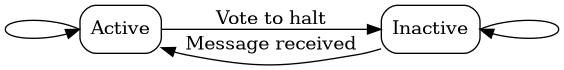

In [5]:
from graphviz import Digraph
from IPython.display import Image

def pregel_framework():
    dot = Digraph(comment='Pregel Framework')
    
    # Configure graph attributes
    dot.attr(rankdir='LR')  # Left to right layout
    dot.attr('node', shape='box', style='rounded')
    
    # Add nodes
    dot.node('active', 'Active')
    dot.node('inactive', 'Inactive')
    
    # Add edges with arrows
    dot.edge('active:w', 'active:w')
    dot.edge('inactive:e', 'inactive:e')
    dot.edge('active', 'inactive', label="Vote to halt")
    dot.edge('inactive', 'active', label="Message received")

    return dot

# Create and save the graph
flow = pregel_framework()
flow.render('pregel_framework', format='png', cleanup=False)
Image("./pregel_framework.png")

### Message Passing
- Vertices Communicate with one another by sned messages, each of which consists a message value and the name of the destination vertex.
- A vertex can send any number of message in a supertesp
- A message sent at superset S will be recieved at S+1
- Messages can be sent to non-neighbour vertex also if the vertex id is known

### Combiners (optimization)
- This reduces the overhead of sending multiple messages with the help of user
- Suppose that Computer() receives integer message and that only the sum of the messages matter in that cases the system can combine all the messages for a vertex
- For some algorithms, such as a single-source shortest paths we have observed more than a fourfold reduction in message traffic by using combiner.

### Aggregators
- Pregel aggregators are a mechanism for global communication, monitoring, and data
- Each vertex can provide a value to an aggregator in superstep S, the system combines those values using a reduction operator, and the resulting value is made available to all vertices in superstep S + 1
- Custom aggregator can be defined by user using predefined subclasses Aggregator, and specifies how the aggregated value is initialized from the first input value and how multiple partially aggregated valuse are reduced to one, Aggregation operators should be communtative and associative

### Input and Output
Pregel decouples the task of interpreting an input file as a graph from the task of graph computation. Similarly, output can be generated in an arbitrary format and stored in the form most suitable for a given application.

Pregel library provides readers and writers for many common file formats, but users with unusual needs can write their own by subclassing the abstract base classes Reader and Writer.

### Basic Architecture
The Pregel library divides a graph into partitions, each consisting of a set of vertices.

Assignment of a vertex to a partition depends solely on the vertex ID, which implies it is possible to know which partition a given vertex belongs on even if the vertex is owned by a different machine, or even if the vertex does not yet exist.

The default partitioning function is just hash(ID) and mod N, where N is the number of partitions, but users can replace it.

After the input has finished loading, all vertices are marked as active.

The master instructs each worker to perform a superstep. The worker loops through its active vertices, using one thread for each partition.

The worker calls Compute() for each active vertex, delivering messages that were sent in the previous superstop. When the worker is finished it responds to the master, telling the master how many vertices will be active in the next superstep. This step is repeated as long as any vertices are active or any messages are in transit.

After the computation halts, the master may instruct each work to save its portion of the graph.

### Fault Tolerance
Fault Tolerance is achieved through checkpointing. At the beginning of a superstep the master instructs the workers to save the state of their partitions to persistence storage.

Worker Failures are detected using regular "ping" messages that the master issues to the workers.

When one or more workers fail, the current state of the partitions assigned to these workers is lost. The master reassigns graph partitions to the currently available set of workers, and they all reload their partition state from the most recent available checkpoint at the beginning of a superstep S. That checkpoint may be several supersteps earlier than the latest superstep S" completed by any partition before the failure, rrequiring that recovery repeat the missing supersteps.

Confined recovery:

In addition to the basic checkpoints, the workers also log outgoing messages from their assigned partitions during graph loading and supersteps. Recovery is then confined to the lost partitions, which are recovered from checkpoints. The system recomputes the missing supersteps up to S" using logged messages from healthy partitions and recalculated ones from recovering partitiions.

This approach saves compute resources during recovery by only recomputing lost partitions, and can improve the latency of recovery since each work may be recovering fewer partitions.

### Worker Implementation
A worker machine maintains the state of its portion of the graph in memory.
Conceptually this can be thought of as a map from vertex ID to the state of each vertex, where the state of each vertex consists of its current value, a list of its outgoing edges. A queue containing incoming messages, and a flag specifying whether the vertex is active.

A worker processes its vertices in superstep S it is simultaneously, in another thread, receiving messages from other workers executing the same superstep.

Message spending can be optimized based the destination location (remote or local)


### Master Implementation
The master is primarily responsible for coordinating hte activities of workers. Each woker is assigned a unique identifier at the time of its registration.

The master maintains a list of all workers currently known to be alive, including the worker's unique identifier, its addressing information, and which protion of the graph it has been assigned.

Most master operations, including input, output, computation, and saving and resuming from checkpoints.

The master also maintains statistics about the progress of computation and the state of the graph.

# Agents
Agent can be defined in serveral ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. others use the term to describe predifine workflows.

An important architectural distinciton between workflows and agents:
- Workflows are ssystems wehre LLMs and tools are orchestrated through predefined code paths.
- Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

When to use agents

When more complexity is warranted, workflows offer predictability and consistency for well-defined tasks, whereas agents are the better option when flexibility and model-driven decision-making are needed at scale. For many applications, however, optimizing single LLM calls with retrieval and in-context examples is usually enough.



